# Watching Electrons Absorb Light

I wanted connect this blog to some of the things I worked on while getting my PhD. I'm going to explain a little about how to make a movie using data from a calculation I would do. Note: I didn't actually do these calculations, but I did make the videos. 

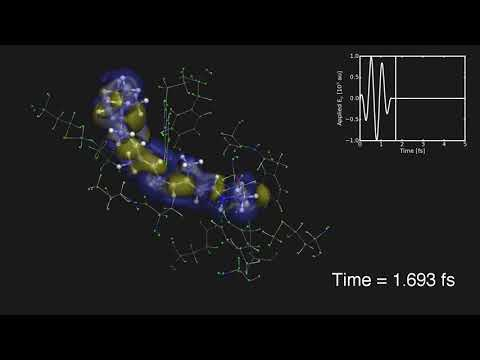

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Tj0bNTKHSQs',width=800, height=450)

# Quantum Refresher

Electronic structure theory (EST) is the study of electrons using quantum mechanics. Electrons are super important in chemistry! They’re the glue that hold moelcules together and you can understand a lot of reactions by understand how they move. I wanted to explain how to visualize electrons as they’re described in my calculations. But before we get to that, I want to give a quick refresher on quantum mechanics. 

You’ve likely heard the idea that electrons can act as both [particles and as waves]( https://en.wikipedia.org/wiki/Wave%E2%80%93particle_duality). This idea comes from the concept of a “wave function”, which describes the position and momentum of a particle. What a wave function really “means” is rather complicated, so I’ll just point you to [Wikipedia](https://en.wikipedia.org/wiki/Wave_function) and references therein. From its wave function you can determine a probability distribution of an electron’s likely position and momentum. If we can visualize the wave function (or this probability distribution), then we can see where electrons like to hang out in a molecule.

Here's an example for a quantum harmonic oscillator. It looks like a bunch of sine *waves* oscillating in time. This is a lot like what we'll be visualing for the electrons, but in three dimensions instead of one. 

In [2]:
%%html
<p>
<a href="https://commons.wikimedia.org/wiki/File:QuantumHarmonicOscillatorAnimation.gif#/media/File:QuantumHarmonicOscillatorAnimation.gif">
<img src="https://upload.wikimedia.org/wikipedia/commons/9/90/QuantumHarmonicOscillatorAnimation.gif" alt="QuantumHarmonicOscillatorAnimation.gif" width=400></a>
<br>By <a href="//commons.wikimedia.org/wiki/User:Sbyrnes321" title="User:Sbyrnes321">Sbyrnes321</a> - 
<span class="int-own-work" lang="en">Own work</span>, 
<a href="http://creativecommons.org/publicdomain/zero/1.0/deed.en" title="Creative Commons Zero, Public Domain Dedication">CC0</a>, 
<a href="https://commons.wikimedia.org/w/index.php?curid=14059905">Link</a>
</p>

This will be let us watch how electrons move during a reaction! 

When you want to model a large molecule, it’s sometimes easier to break it up into important and less important regions. The calculation I want to visualize has a section modeled with quantum mechanics (QM) and a section modeled with classical mechanics or molecular mechanics (MM). This is a practical way to describe a large molecule that you can’t afford to use quantum mechanics to describe. Plus this concept led to a couple [Nobel prizes in 2013](https://cen.acs.org/articles/91/i41/2013-Nobel-Prize-Chemistry.html), so I think it’s safe to say it’s a useful tool.

In [3]:
from IPython.display import Image
Image(url="http://pubs.rsc.org/services/images/RSCpubs.ePlatform.Service.FreeContent.ImageService.svc/ImageService/Articleimage/2012/CS/c2cs15297e/c2cs15297e-f3.gif", width=600)

In this post, we’re going to look at a calculation where some of the electrons have wave functions (in the QM part) and where the rest of the electrons are approximated by [dipoles](https://en.wikipedia.org/wiki/Dipole) (in the MM part). All the theory and background for the method used in this post can be found in a [great paper](http://pubs.acs.org/doi/10.1021/acs.jpclett.7b02320) published earlier this year. 

# Visualization Strategy

We need a way to plot the electrons in the QM region and in the MM region. The common strategy in EST is to generate a 3D grid representing the spatial extent of some function: either a one-electron wave function or the total electronic density. This is usually referred to as a [cube file](http://gaussian.com/cubegen/). After picking a value for this function, you can plot an [isosurface](https://en.wikipedia.org/wiki/Isosurface) to see what it looks like. There are a number of software packages ([Avogadro](https://avogadro.cc/), [Molden](http://www.cmbi.ru.nl/molden/), [GaussView](http://gaussian.com/gv6glance/)) that can generate cube files and visualize isosurfaces using information from standard quantum chemistry software packages ([ORCA](https://orcaforum.cec.mpg.de/), [DALTON](http://daltonprogram.org/), [Gaussian](http://gaussian.com/)). For the MM region, we want to represent the dipole on each atom. We can do this by plotting an arrow along the vector defining the dipole originating from that atom. 

Generating a single image is pretty straightforward with the visualization packages I mentioned above. But we’re trying to make a movie! So we need to make a lot of images all using slightly different information from the simulation. I’ve found [PyMOL](https://www.schrodinger.com/pymol) to be a great tool for this. It’s built off python, so if you know any python, then PyMOL can definitely be a friend to you. The newest version is not free, but there are older open-source versions that you can find online through [various package managers](https://pymolwiki.org/index.php/Category:Installation). With this it’s easy to loop through all the information from our calculation and render the movie one frame at a time. 


# Getting to the Fun Stuff

We’ll get into an example showing the dynamics of [rhodopsin](https://en.wikipedia.org/wiki/Rhodopsin). Actually, we’re going to look at a very small part of rhodopsin for simplicity, but you could certainly scale this up to the whole protein if you have the computational resources. This is based off a similar [example on Github](https://github.com/liresearchgroup/pymol-movie). You can grab this code from that repository as well. 

First we'll import some useful things for later on. 

In [4]:
import os
import sys
import csv

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

from subprocess import call
from itertools import takewhile

The first thing we need to do is build all the cube files representing how the electron density changes over the course of the simulation. We’re going to view the density difference relative to the initial density. It’s easier to see what’s going on if we focus on the change instead of the whole thing. We’ll also be taking the same approach when visualizing the dipoles in the MM region. My first script **build_cubes.py** loops over the densities printing in the output file from the simulation, places them in a formatted checkpoint file, and then used Gaussian’s [cubegen](http://gaussian.com/cubegen/) utility to build the cube files. After this point, we can render all the frames with PyMOL. 

In [ ]:
from gauss_parse import *

#------------------------------------------------------------------------------
def grab_densities(f_name):
    ''' Grab densities out of the log file. 

        nbasis:   The number of basis functions 
        den_real: List of numpy arrays for the real part of the densities
        den_imag: List of numpy arrays for the imaginary part of the densities
    '''

    # Find the number of basis functions
    with open(f_name, 'r') as f:
        for line in f:
            if 'basis functions' in line:
                nbasis = int(line.split()[0])

    # Find the real densities
    den_real = []
    with open(f_name) as f:
        for line in f:
            if line.startswith(' Density (real)'):              
                data = ''.join(list(takewhile(lambda x: not 
                         x.startswith(' Density (imaginary)'),f))).split()
                data = [d.replace('D','E') for d in data]
                elements = []
                for value in data[1:]: 
                    if 'E' in value: 
                        elements.append(value)
                den_real.append(make_symmetric(create_matrix(elements,nbasis)))
                print("Have %d real densities" % len(den_real))

    return nbasis, den_real
#------------------------------------------------------------------------------

# define the name of the input files
logfile, fchkfile = sys.argv[1], sys.argv[2]

# grab the densities from the logfile
nbasis, d_r = grab_densities(logfile)
ntt = nbasis * (nbasis+1) / 2

# define the ground state density and first zero density
ground_density = d_r[0]
d_r[0] -= ground_density 

# define how many densities to skip 
nskip = 1

# create a directory to store the new fchk/cube files
directory = 'fchk-cube-files'
if not os.path.exists(directory):
    os.makedirs(directory)

# create new fchk files using the grabbed densities
for i, density in enumerate(d_r):

    print('Building fchk for density : ', i)
    if i % nskip == 0:
   
        # grab the LT form the of the density to put in the fchk file 
        il = np.tril_indices(nbasis)
        density  = density[il]
        density  = [float(d) for d in density]

        # everything is in rows of 5 numbers
        remainder = ntt % 5

        # generate the list of strings for writing the density
        den_list = []
        for j in range(0,ntt-remainder,5):
            den_string = '%16.8E'*5 % (density[j], density[j+1], density[j+2], 
                 density[j+3], density[j+4])
            den_list.append(den_string)
        if remainder != 0:
            mod_list = []
            for k in range(remainder,0,-1): 
                mod_list.append(density[k])
            den_string = '%16.8E'*remainder % mod_list
            den_list.append(den_string)
     
        # write the density difference to the fchk file
        new_fchk  = '%s/%s-%04d.fchk' % (directory, fchkfile.split('.')[0], i)
        template  = open(fchkfile,'r')
        new_f     = open(new_fchk,'w')
        write_den, d_list_count = False, 0
        for line in template:
            # figure out where to write density
            if 'SCF Density' in line:
                write_den  = True
                den_header = line
            if 'Mulliken Charges' in line:
                write_den = False
    
            # write the density difference if at the right spot
            if write_den:
                if d_list_count == 0: 
                    new_f.write(den_header)
                else:
                    new_f.write(den_list[d_list_count-1]+'\n')
                d_list_count += 1
            # write the rest of the template fchk file
            else:
                new_f.write(line)
        template.close()
        new_f.close()  
    
        # generate the cube for the density difference
        print('Generating cube for density : ', i)
        cube_file = '%s/%s-%04d.cube' % (directory, fchkfile.split('.')[0], i)
        call(['cubegen','0','density=scf',new_fchk,cube_file])  

        # fix the cube file to be read by pymol
        # Note: newer versions of cubegen add an extra '1' to the 3rd line 
        #       and this needs to be removed so pymol can read it correctly
        data = open(cube_file,'r').read().replace('    1\n',' \n')
        fix_cube = open(cube_file,'w')
        fix_cube.write(data)

The **generate_frames.py** script renders the QM and MM regions of the molecular system differently, so it’s obvious which is which. It plots two isosurfaces for the positive and negative values of the density difference. The MM dipoles are then plotted using functions in **cgo_arrow.py**. PyMOL will render all of these things and output a frame for each time step of the calculation. 

In [ ]:
import pymol

from cgo_arrow import *
from extract_dipoles import *

#------------------------------------------------------------------------------
def return_geometry(f_xyz):
  ''' Grab lists of x/y/z coordinates from a file 

      Note: this assumes no blank lines in the file 
  '''

  x, y, z = [], [], []
  f = open(f_xyz,'r')
  for line in f:
    contents = line.split()
    x.append(float(contents[1])) 
    y.append(float(contents[2])) 
    z.append(float(contents[3])) 

  return x, y, z
#------------------------------------------------------------------------------

# define file names
logfile    = 'water-qmmmpol-rt.log'
fchkfile   = 'water-qmmmpol-rt.fchk'
qm_geom    = 'qm.xyz'
mm_geom    = 'mm.xyz'
mm_origins = 'mm-origins.xyz'

# grab the positions of the mm atoms
# Note: this may be a truncated list compared to the whole MM geometry since
#       not all sites may have induced dipoles
# Note: this code assumes that these origins are in the same order as those
#       printed in the logfile
mm_x, mm_y, mm_z = return_geometry(mm_origins)
n_mm = len(mm_x)

# grab the dipoles from the log file
dipoles = extract_dipoles(logfile,n_mm)

# start pymol 
pymol.finish_launching()

# start numbering for the frames (not the same as the cubes)
file_num = 0

# define how many cube files to skip and how often the density difference
# was printed during the RT calculation
nskip, nprint = 1, 10

# define the starting and ending indices for the cube files 
istart, iend = 0, 10

# define the isosurface value and the scale factor for the MM dipoles
iso_val, scale = 0.0004, 50

# create a directory to store the new fchk/cube files
fchk_cube_dir = 'fchk-cube-files'
frames_dir    = 'pymol-frames'
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Loop over the frames for each step to be rendered 
for i in range(istart,iend,nskip):

    # clear the frame 
    pymol.cmd.reinitialize()

    # plot the qm region
    pymol.cmd.load(qm_geom, 'qm')
    pymol.cmd.show('sticks', 'qm')
    pymol.cmd.show('spheres', 'qm')
    pymol.cmd.set('stick_radius',0.1,'qm')
    pymol.cmd.set('sphere_scale',0.2)
    
    # plot the mm region
    pymol.cmd.load(mm_geom, 'mm')
    pymol.cmd.show('sticks', 'mm')
    pymol.cmd.set('stick_radius',0.025,'mm')
    pymol.cmd.color('gray','name C*')
    
    # plot the density difference
    cube_file  = '%s/%s-%04d.cube' % (fchk_cube_dir, fchkfile.split('.')[0], i)
    print(cube_file)
    pymol.cmd.load(cube_file, 'cube' )
    pymol.cmd.isosurface('surf1', 'cube',  iso_val)
    pymol.cmd.isosurface('surf2', 'cube', -iso_val)
    pymol.cmd.color('tv_yellow', 'surf1')
    pymol.cmd.color('tv_blue','surf2')
    pymol.cmd.set('transparency', 0.6, 'surf1')
    pymol.cmd.set('transparency', 0.6, 'surf2')
    
    # plot the dipole differences
    for j in range(n_mm):
        name = 'arrow-%03d' % j
        o_x, o_y, o_z = mm_x[j], mm_y[j], mm_z[j]
        e_x, e_y, e_z = o_x + scale*dipoles[nprint*i][0][j], \
                        o_y + scale*dipoles[nprint*i][1][j], \
                        o_z + scale*dipoles[nprint*i][2][j]
        cgo_arrow(atom1=[o_x,o_y,o_z],atom2=[e_x,e_y,e_z],color='tv_green',
                  radius=0.025,name=name)

    # reset the camera 
    # Note: this needs to be determined for each system individually through
    #       trial and error
    pymol.cmd.zoom()
    pymol.cmd.turn('x',30)
    pymol.cmd.turn('z',60)
    pymol.cmd.zoom('center', 4)
    pymol.cmd.turn('x',-90)
    pymol.cmd.turn('z',20)
    pymol.cmd.turn('x',20)
    pymol.cmd.move('x',-0.5)

    # save the frame
    out_file = '%s/frame-%04d' % (frames_dir, file_num)
    pymol.cmd.bg_color(color="grey10")
    pymol.cmd.set('volume_layers',2000)
    pymol.cmd.draw(1600,900)
    pymol.cmd.png(out_file,dpi=400.0)

    file_num += 1

The next step is optional. If the simulation involves applying a field to the system, you may want to show that in the movie. The **add_field.py** script will grab the field definition from the output file and plot it over the frames generated with PyMOL. 

In [ ]:
#------------------------------------------------------------------------------
def grab_field(logfile):
    '''
    Grab the field from a log file and save it in field.csv
    '''

    dip_x, dip_y, dip_z, time = [], [], [], []

    f = open(logfile,'r')
    for line in f:

      # grab the field 
      if 'Ex=' in line and 'Ey=' in line: 
        contents = line.split() 
        dip_x.append(contents[1])
        dip_y.append(contents[3])
        dip_z.append(contents[5])

      # grab the time
      if 'Time =' in line:
        contents = line.split() 
        time.append(contents[2])
    f.close()

    # build the list of parameters and write to the file
    write_list = []
    for i in range(len(dip_x)):
      write_list.append([time[i],dip_x[i],dip_y[i],dip_z[i]])
    with open("field.csv","wb") as f:  
        cw = csv.writer(f)
        cw.writerows(write_list)
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
def plot_field(istart,iend,nskip,timestep,nprint,direction,field_dir):
    '''
    Plot the field stored in field.csv

    Saves several transparent images in the field_dir folder. Each image plots 
    one direction of the field and has a verticle line for the current time. 
    '''

    au2fs = 0.0241888425
    field = np.genfromtxt('field.csv',skip_header=1,delimiter=',')

    direction_dict = {'x': 1, 'y': 2, 'z': 3}
    t = field[:,0]*au2fs
    E = field[:,direction_dict[direction]]*1e3
    
    file_num = 0
    for step in range(istart,iend,nskip):
        filename = '%s/field-%04d' % (field_dir, file_num)
        print(filename)
    
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.setp(ax.spines.values(), linewidth=4, color='white')
    
        plt.plot(t,E,lw=4,color='white')
        plt.axvline(nprint*timestep*step*au2fs,color='white',lw=4)
    
        # label Y axis and make it white
        ylabel = plt.ylabel("Applied E$_%s$ [10$^{3}$ au]" % direction)
        ylabel.set_color('white')

        # label X axis and make it white
        xlabel = plt.xlabel("Time [fs]")
        xlabel.set_color('white')
    
        # make x and y tick labels white as well
        [i.set_color("white") for i in plt.gca().get_xticklabels()]
        [i.set_color("white") for i in plt.gca().get_yticklabels()]
        plt.tick_params(which='both', width=4, color='white')
    
        plt.gcf().subplots_adjust(left=0.2,bottom=0.15)
#       plt.xlim(0,5)
        
        plt.savefig(filename+'.png',transparent=True)
        plt.close()

        file_num += 1
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
def add_field_to_frame(nskip,nprint,size,nfiles,timestep,field_dir,frames_dir):
    '''
    Adds the generated plots of the field to the frame generated in pymol
    '''

    au2fs = 0.0241888425

    # loop over each file and add the appropriate image for the field
    for nfile in range(nfiles):
        print("Working on nfile = ", nfile)
    
        # define name of image with field
        field_name = '%s/field-%04d' % (field_dir, nfile)
 
        # define name of image from pymol
        frame = '%s/frame-%04d' % (frames_dir, nfile)
   
        # add the field to the frame 
        img   = Image.open(frame+'.png')
        field = Image.open(field_name+'.png')
        field.thumbnail(size, Image.ANTIALIAS) 
        img.paste(field,(1100,0),mask=field)
    
        # add the time to the frame
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype("Helvetica.ttf",80)
        time = nskip*nprint*nfile*timestep*au2fs
        captiontext = "Time = %.3f fs" % time
        wh = font.getsize(captiontext)
        draw.text((img.size[0] - 1.2*wh[0],img.size[1] - 3.5*wh[1]), 
                  captiontext, (255,255,255), font=font)

        final_image = '%s/frame-%04d-with-field.png' % (field_dir, nfile)      
        img.save(final_image)
#------------------------------------------------------------------------------

# define how many cube files to skip and how often the density difference
# was printed during the RT calculation
nskip, nprint = 1, 10

# define the starting and ending indices for the cube files 
istart, iend = 0, 10

# define time step from RT calculation in au
timestep = 0.01

# define the direction of the applied field
direction = 'z'

# define the size of the added image
size = 500, 500

# extract the field from the log file
logfile = sys.argv[1]
grab_field(logfile)

# plot the field for each frame
field_dir  = 'pymol-frames-w-field'
if not os.path.exists(field_dir):
    os.makedirs(field_dir)
plot_field(istart,iend,nskip,timestep,nprint,direction,field_dir)

# add the field and the time to the frame
frames_dir = 'pymol-frames'
nfiles = len(list(range(istart,iend,nskip)))
add_field_to_frame(nskip,nprint,size,nfiles,timestep,field_dir,frames_dir)

The last thing to do is combine all the frames into a single movie. You can use [ffmpeg](https://www.ffmpeg.org/) to accomplish this pretty easily. At the end of the day you have a beautiful movie showing how the electrons move around in a complex simulation. 

Here's one more video showing the full version of the video in the Github example. I hope you enjoy these videos! 

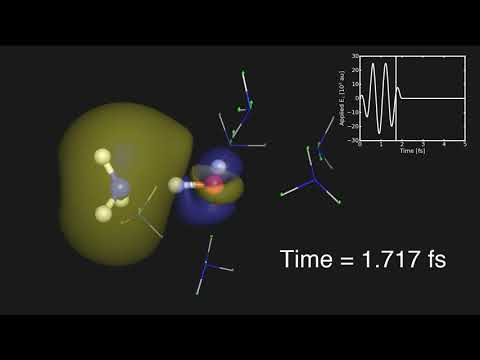

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('JckYRO7C8Ww',width=800, height=450)